In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path


def override_sys_breakpoint(frame=None):
    from IPython.core.debugger import set_trace

    set_trace(frame=frame)


sys.breakpointhook = override_sys_breakpoint

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


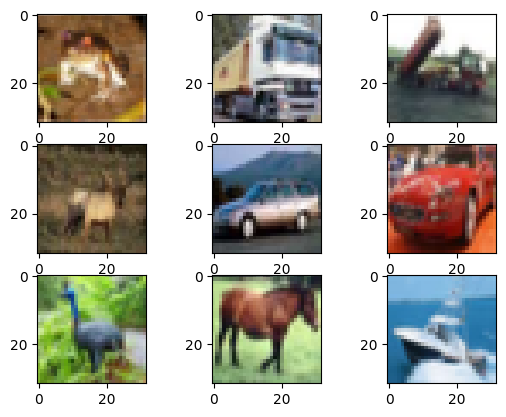

In [4]:
from tensorflow.keras.datasets import cifar10

(trainX, trainy), (testX, testy) = cifar10.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i][:,::-1, :]/255)# + np.random.normal(size=trainX[i][:,::-1, :].shape) * 1e-1)

plt.show()

In [5]:
n_data = 40
train_images = trainX[:n_data]
train_labels = pd.get_dummies(trainy[:n_data,0]).values
test_images = testX[:n_data]
test_labels = pd.get_dummies(testy[:n_data,0]).values
n_cls = train_labels.shape[1]

In [6]:
train_images.shape

(40, 32, 32, 3)

In [7]:
style = 'conv'

In [8]:
if style == 'fc':
    x = train_images.reshape(train_images.shape[0], -1)
    x_tst = test_images.reshape(test_images.shape[0], -1)
    num_features = x.shape[1]
else:
    x = train_images
    x_tst = test_images
    num_features = 3
x_mean, x_std = x.mean(), x.std()
x = (x - x_mean) / x_std
x_tst = (x_tst - x_mean)/ x_std
y = train_labels
y_tst = test_labels

In [9]:
from utils import LeakyRelu, FlattenNp
from dense_np import DenseNp

In [10]:
from conv_np import ConvNp


In [11]:
class Model:
    def __init__(self, layer_shapes, lr = 1e-1, momentum = 0.0, style = 'fc', target_shape = None):
        self.lr = lr
        self.style = style
        self.losses = []
        self.layers = []
        for in_shape, out_shape in zip(layer_shapes[:-1], layer_shapes[1:]):
            if style == 'fc':
                self.layers.append(DenseNp(in_shape, out_shape, momentum = momentum))
            elif style == 'conv':
                self.layers.append(ConvNp(in_shape, out_shape, momentum = momentum))
                
            self.layers.append(LeakyRelu())
        if style == 'conv':
            self.layers.append(FlattenNp())
            self.layers.append(LeakyRelu())
            self.layers.append(DenseNp(layer_shapes[-1] * 32 * 32, target_shape, momentum = momentum))
        else:
            # self.layers = self.layers[:-1]
            self.layers.append(DenseNp(out_shape, target_shape, momentum = momentum))

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, x = None, y= None, err = None):
        if err is None:
            err = self.err(x, y)
        return np.square(err).mean()
    
    def err(self, x, y):
        yhat = self.predict(x)
        return (y - yhat)
        
        
    def train_fullbatch(self, x, y, steps, **kwargs):
        
        for step in range(steps):
            err = self.err(x, y)
            self.losses.append(self.loss(err = err))
            grad_layer = err / y.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
            
    def train_one_epoch(self, x, y, batch_size):
        data_order = np.random.choice(x.shape[0], x.shape[0], replace=False)
        num_batch = x.shape[0]//batch_size
        minibatch_losses = 0
        for batch_idx in range(num_batch):
            if batch_idx == num_batch - 1:
                sample_idxs = data_order[batch_idx * batch_size:]
            else:
                sample_idxs = data_order[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            x_sample = x[sample_idxs]
            y_sample = y[sample_idxs]
            err = self.err(x_sample, y_sample)
            minibatch_losses += self.loss(err = err)
            grad_layer = err / y_sample.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
        self.losses.append(minibatch_losses)
        
        
    def train_minibatch(self, x, y, epochs, batch_size = 8):
        import tqdm
        for epoch in tqdm.tqdm(range(epochs)):
            self.train_one_epoch(x, y, batch_size = batch_size)
        
    def train(self, x, y, steps, style = 'fullbatch', **kwargs):
        {'minibatch': self.train_minibatch, 'fullbatch': self.train_fullbatch}[style](x, y, steps, **kwargs)
    def viz(self, skip_first = 0):
        plt.plot(self.losses[skip_first:])

In [12]:
mdl = Model([num_features, 16, 16], momentum = 0, lr = 1e-6, style = style, target_shape = y.shape[1])

In [13]:
mdl.train(x, y,10 , style = 'minibatch')

100%|██████████████████████████████████████████| 10/10 [00:58<00:00,  5.80s/it]


In [14]:
# %timeit mdl.train(x, y,10 , style = 'minibatch')

In [15]:
mdl.predict(x).shape

(40, 10)

In [16]:
y.shape

(40, 10)

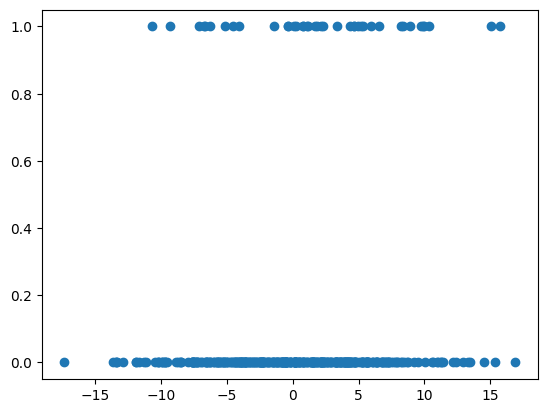

In [17]:
plt.scatter(mdl.predict(x), y)

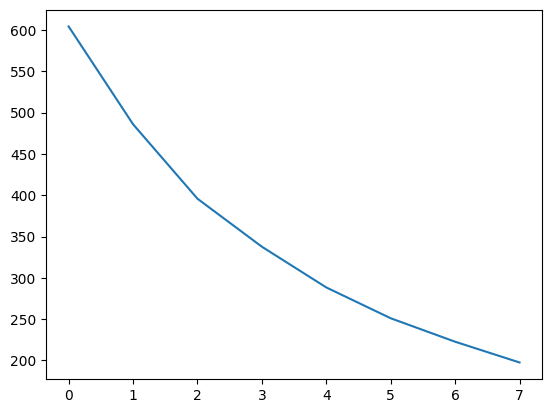

In [18]:
mdl.viz(skip_first = 2)

In [19]:
mdl.loss(x, y[:,None])

34.069338375855565